# **6장. 합성곱 신경망 2**

In [41]:
pip install --user tqdm

# 6.1 이미지 분류를 위한 합성곱 신경망

유형:

**6.1.1 LeNet-5**

합성곱과 다운 샘플링(=풀링)을 반복적으로 거치며, 마지막에 완전연결층에서 분류를 수행하는 것

In [ ]:
#1. 필요한 라이브러리 호출

import time
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms #이미지 변환(전처리) 기능을 제공하는 라이브러리
from torch.autograd import Variable
from torch import optim #경사하강법 이용하여 가중치 구하기 위한 옵티마이저 라이브러리
import torch.nn as nn
import torch.nn.functional as F
import os #파일 경로에 대한 함수 제공
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm #진행상황(ex: 모델 학습 경과)을 가시적으로 표현해주는 라이브러리
import random
from matplotlib import pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [42]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [43]:
#2. 이미지 데이터세트 전처리

class ImageTransform() :
  def __init__(self, resize, mean, std) :
    self.data_transform = {
        'train' : transforms.Compose([
            transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)), #입력이미지를 주어진 크기로 조정(기본 224x224) / 원래 이미지를 무작위 크기(50~100%)만큼 면적 자름
            transforms.RandomHorizontalFlip(), #일정 확률(기본 50%)로 이미지 수평 반전
            transforms.ToTensor(), #효율적인 연산 위해 텐서로 변환
            transforms.Normalize(mean, std) #각 채널별 평균(mean)과 표준편차(std) 정규화
                                      ]),
        'val' : transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    }

  def __call__(self, img, phase) : #__call__함수: 클래스 객체 자체를 호출하면 해당 함수의 리턴값 반환
    return self.data_transform[phase](img)

In [44]:
from posixpath import supports_unicode_filenames
#이미지 데이터세트 훈련, 검증, 테스트 세트로 분리

cat_directory = r'/content/drive/MyDrive/pytorch_ex/chap06/data/dogs-vs-cats/Cat'
dog_directory = r'/content/drive/MyDrive/pytorch_ex/chap06/data/dogs-vs-cats/Dog'

cat_images_filepaths = sorted( [os.path.join(cat_directory, f) for f in os.listdir(cat_directory)] )
#sorted: 데이터를정렬된 리스트로 만들어서 반환 / os.path.join: 경로와 파일명 결합,또는 분할된 경로 하나로 합칭
# os.listdir: 해당 디렉토리 내 모든 파일 리스트 반환(이미지파일 모두 반환)
dog_images_filepaths = sorted( [os.path.join(dog_directory, f) for f in os.listdir(dog_directory)] )
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths] #개와 고양이 이미지 합쳐서 images_filepaths에 저장
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[400:-10]
test_images_filepaths = correct_images_filepaths[-10:]

print( len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


In [45]:
#테스트 데이터셋에 어떤 데이터들이 있는지 확인하는 함수
def display_image_grid(images_filepaths, predicted_labels=(), cols=5) :
  rows = len(images_filepaths) // cols
  figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
  for i, image_filepath in enumerate(images_filepaths) :
    image = cv2.imread(image_filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #입력 이미지 / 변환할 이미지 색상 지정(BlueGreenRed -> RGB컬러)
    true_label = os.path.normpath(image_filepath).split(os.sep)[-2] #경로명 정규화  /  '/'나 '\'기준 분할   /   뒤에서 2번쨰
    predicted_label = predicted_labels[i] if predicted_labels else true_label
    color = 'green' if true_label == predicted_label else 'red'
    ax.ravel()[i].imshow(image) #개별 이미지 출력
    ax.ravel()[i].set_title(predicted_label, color=color)
    ax.ravel()[i].set_axis_off()
  plt.tight_layout()
  plt.show()

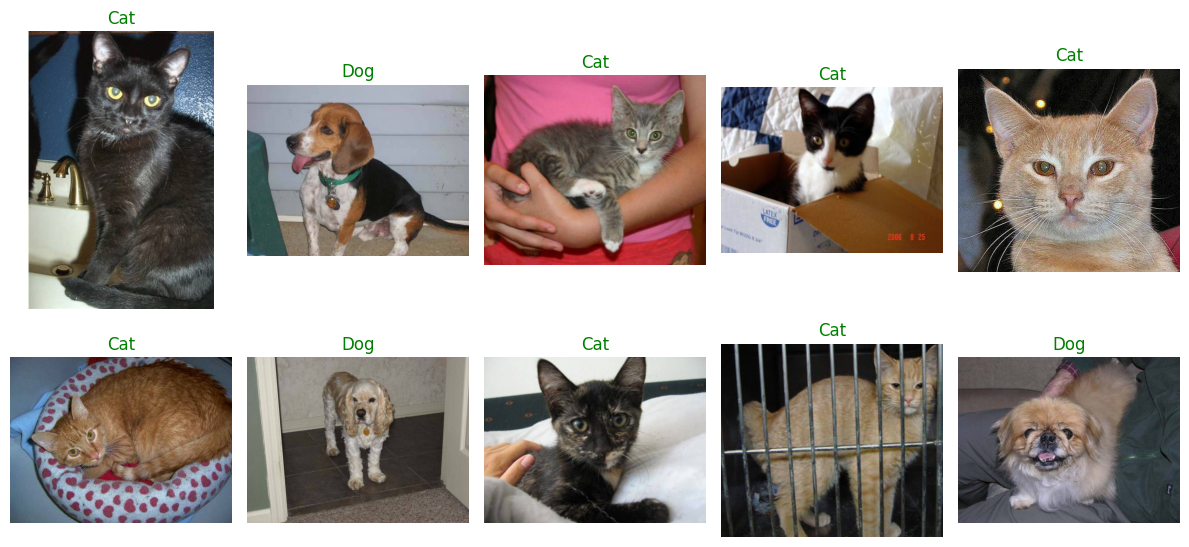

In [46]:
#테스트 데이터세트 이미지 출력
display_image_grid(test_images_filepaths)

In [47]:
#이미지 데이터세트 클래스 정의
class DogVsCatDataset(Dataset) :
  def __init__(self, file_list, transform=None, phase='train') : #데이터셋 전처리하여 적용
    self.file_list = file_list #데이터 경로 저장
    self.transform = transform
    self.phase = phase

  def __len__(self) :
    return len(self.file_list) #images_filepaths 데이터셋 전체 길이 반환

  def __getitem__(self, idx) :
    img_path = self.file_list[idx] #해당 인덱스 이미지의 경로
    img = Image.open(img_path) #경로에서 이미지 데이터 가져옴
    img_transformed = self.transform(img, self.phase) #이미지 'train' 전처리

    label = img_path.split('/')[-1].split('.')[0] #이미지 데이터 경로에 있는 레이블('dog', 'cat') 가져옴
    if label == 'dog' :
      label = 1
    elif label == 'cat' :
      label = 0
    return img_transformed, label

In [48]:
#전처리에 사용할 변수 값 정의
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [49]:
#훈련세트, 검증세트 정의

train_dataset = DogVsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogVsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
#torch.Size([3, 244, 244]) >> 이미지가 '컬러' 상태에서 224x224 크기를 가짐
print(train_dataset.__getitem__(index)[1])
#0 또는 1 >> 고양이 또는 개

torch.Size([3, 224, 224])
0


In [50]:
#데이터 로더 정의
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #데이터를 배치 단위로 쪼개어, 랜덤으로 불러옴
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = { 'train':train_dataloader, 'val':val_dataloader }

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
        1, 0, 1, 1, 1, 0, 1, 0])


In [51]:
#모델의 네트워크 설계 클래스
class LeNet(nn.Module) :
  def __init__(self) :
    super(LeNet, self).__init__()
    self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0) #2D 합성곱층. 입력형태 (3,224,224)
    self.relu1 = nn.ReLU()
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)

    self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
    self.relu2 = nn.ReLU()
    self.maxpool2 = nn.MaxPool2d(kernel_size=2)

    self.fc1 = nn.Linear(32*53*53, 512)
    self.relu5 = nn.ReLU()
    self.fc2 = nn.Linear(512, 2)
    self.output = nn.Softmax(dim=1)

  def forward(self, x) :
    out = self.cnn1(x)
    out = self.relu1(out)
    out = self.maxpool1(out)

    out = self.cnn2(out)
    out = self.relu2(out)
    out = self.maxpool2(out)

    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.fc2(out)
    out = self.output(out)

    return out

In [52]:
#복붙

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU() # activation
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32*53*53, 512)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512, 2)
        self.output = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.output(out)
        return out

In [53]:
#모델 객체 생성
model = LeNet().to(device)
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


In [54]:
pip install torchsummary

In [55]:
from torchsummary import summary #출력 결과를 더 한 눈에 들어오게 볼 수 있는 라이브러리
summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
            Linear-8                    [-1, 2]           1,026
           Softmax-9                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Estimated Total Size (MB): 195.67
--------------------------------

In [56]:
#모델의 학습 가능한 파라미터 수 확인
def count_parameters(model) :
  return sum( p.numel() for p in model.parameters() if p.requires_grad )

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 46,038,242 trainable parameters


In [57]:
#옵티마이저와 손실 함수 정의
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

#모델의 파라미터, 손실함수 ->cpu
model = model.to(device)
criterion = criterion.to(device)

In [58]:
#모델 학습시키는 함수 정의

def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            epoch_loss = 0.0
            epoch_corrects = 0

            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return model

In [59]:
#모델 학습

num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


<ipython-input-58-906bfaa6e820>:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6947 Acc: 0.4825


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6966 Acc: 0.4565
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6906 Acc: 0.5125


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7113 Acc: 0.4891
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6841 Acc: 0.5700


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7058 Acc: 0.4783
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6818 Acc: 0.5650


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6941 Acc: 0.5000
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6854 Acc: 0.5725


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6903 Acc: 0.5217
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6775 Acc: 0.5900


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7017 Acc: 0.5217
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6766 Acc: 0.5625


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6968 Acc: 0.5217
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6698 Acc: 0.5875


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6926 Acc: 0.5217
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6661 Acc: 0.6025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6904 Acc: 0.5326
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6558 Acc: 0.6475


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6925 Acc: 0.5217
Training complete in 5m 60s
Best val Acc: 0.532609


In [60]:
#모델 테스트를 위한 함수 정의
import pandas as pd

id_list = []
pred_list = []
_id = 0

with torch.no_grad() : #역전파 중 가중치 업데이트 필요 없음을 나타냄(학습단계와의 가장 큰 차이)
  for test_path in tqdm(test_images_filepaths) :
    img = Image.open(test_path)
    _id = test_path.split('/')[-1].split('.')[1]
    transform = ImageTransform(size, mean, std)
    img = transform(img, phase='val') #테스트셋 전처리 적용
    img = img.unsqueeze(0)
    img = img.to(device)

    model.eval()
    outputs = model(img)
    preds = F.softmax(outputs, dim=1)[:, 1].tolist()
    id_list.append(_id)
    pred_list.append(preds[0])

  res = pd.DataFrame({
      'id' : id_list,
      'label' : pred_list
  }) #테스트세트의 예측 결과인 id와 label을 데이터프레임에 저장

  res.sort_values(by='id', inplace=True)
  res.reset_index(drop=True, inplace=True)

  res.to_csv('/content/drive/MyDrive/pytorch_ex/chap06/data/LeNet', index=False)

<ipython-input-60-eb88c2e57114>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths) :


  0%|          | 0/10 [00:00<?, ?it/s]

In [61]:
#테스트 세트 예측 결과 호출
res.head(10) #예측결과가 0.5 이상->개, 0.5 미만->고양이

id     label
0  109  0.491152
1  145  0.397282
2   15  0.558303
3  162  0.505137
4  167  0.491160
5  200  0.443760
6  210  0.565789
7  211  0.545837
8  213  0.414861
9  224  0.585662

In [62]:
#예측결과 시각적으로 표현 위한 함수
class_ = classes = {0:'cat', 1:'dog'}

def display_image_grid(images_filepaths, predicted_labels=(), cols=5) :
  rows = len(images_filepaths) // cols
  figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12,6))
  for i, image_filepath in enumerate(images_filepaths) :
    image = cv2.imread(image_filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    a = random.choice(res['id'].values) #데이터 프레임에 있는 id라는 칼럼에서 임의의 데이터값 가져옴
    label = res.loc[ res['id'] == a, 'label' ].values[0]
    if label > 0.5 :
      label = 1
    else :
      label = 0
    ax.ravel()[i].imshow(image)
    ax.ravel()[i].set_title(class_[label])
    ax.ravel()[i].set_axis_off()
  plt.tight_layout()
  plt.show()

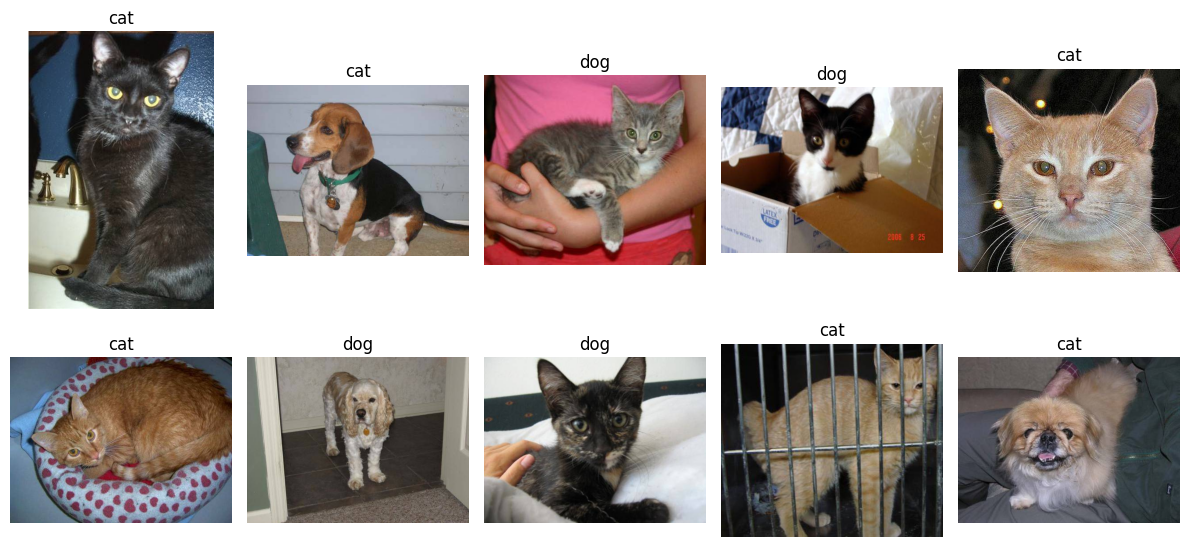

In [63]:
display_image_grid(test_images_filepaths)

**6.1.2 AlexNet**

- 합성곱층 5개, 완전연결층 3개로 구성
- 마지막 완전연결층은 카테고리 1000개 분류를 위한 소프트맥스 함수 사용
- GPU 2개를 기반한 병렬 구조
    - GPU-1 : 컬러와 상관없는 정보를 추출하기 위한 커널이 학습됨
    - GPU-2 : 컬러와 관련있는 정보를 추출하기 위한 커널이 학습됨

In [64]:
#필요한 라이브러리 호출
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import random
from PIL import Image
from tqdm import tqdm_notebook as tqdm
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [65]:
#데이터 전처리

class ImageTransform() :
  def __init__(self, resize, mean, std) :
    self.data_transform = {
        'train' : transforms.Compose([
            transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
        'val' : transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(resize),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
    }

  def __call__(self, img, phase) :
    return self.data_transform[phase](img)

In [66]:
#훈련 검증 테스트 세트 분리
cat_directory = '/content/drive/MyDrive/pytorch_ex/chap06/data/dogs-vs-cats/Cat'
dog_directory = '/content/drive/MyDrive/pytorch_ex/chap06/data/dogs-vs-cats/Dog'

cat_images_filepaths = sorted( [os.path.join(cat_directory, f) for f in os.listdir(cat_directory)] )
dog_images_filepaths = sorted( [os.path.join(dog_directory, f) for f in os.listdir(dog_directory)] )
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[410:]
test_images_filepaths = correct_images_filepaths[400:410]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


In [67]:
#커스텀 데이터 세트 정의

class DogvsCatDataset(Dataset) :
  def __init__(self, file_list, transform=None, phase='train') :
    self.file_list = file_list
    self.transform = transform
    self.phase = phase

  def __len__(self) :
    return len(self.file_list)

  def __getitem__(self, idx) :
    img_path = self.file_list[idx]
    img = Image.open(img_path)
    img_transformed = self.transform(img, self.phase)

    label = img_path.split('/')[-1].split('.')[0]
    if label == 'dog' :
      label = 1
    elif label == 'cat' :
      label = 0

    return img_transformed, label

In [68]:
#변수 값 정의
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [69]:
#훈련 검증 데이터세트 정의
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')
test_dataset = DogvsCatDataset(test_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 256, 256])
0


In [70]:
#데이터셋을 메모리로 불러옴
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train':train_dataloader, 'val':val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 256, 256])
tensor([0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 1, 0, 1])


In [71]:
#AlexNet 모델 신경망 정의
#합성곱층 5, 완전연결층 3

class AlexNet(nn.Module) :

  def __init__(self) -> None :
    super(AlexNet, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),

        nn.Conv2d(64, 192, kernel_size=5, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),

        nn.Conv2d(192, 384, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),

        nn.Conv2d(384, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),

        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2)
                    )
    self.avgpool = nn.AdaptiveAvgPool2d( (6,6) ) #(N, C, H_in, W_in) -> (N, C, H_out, W_out) 출력 크기 조정

    self.classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(256*6*6, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(4096, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 2)
    )


  def forward(self, x: torch.Tensor) -> torch.Tensor :
    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

In [72]:
#model 객체 생성
model = AlexNet()
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [73]:
#옵티마이저, 손실 함수 정의
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [74]:
from torchsummary import summary
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

In [75]:
#모델 학습 함수 정의

def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            epoch_loss = 0.0
            epoch_corrects = 0

            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return model

In [76]:
#모델 학습
num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


<ipython-input-75-6d83973db49a>:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6933 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6939 Acc: 0.4783
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6928 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6940 Acc: 0.4783
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6934 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6940 Acc: 0.4783
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6934 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6940 Acc: 0.4783
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6934 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6939 Acc: 0.4783
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6931 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6941 Acc: 0.4783
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6932 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6940 Acc: 0.4783
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6932 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6939 Acc: 0.4783
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6930 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6939 Acc: 0.4783
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6930 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6937 Acc: 0.4783
Training complete in 9m 40s


In [77]:
#테스트 세트 예측

import pandas as pd

id_list = []
pred_list = []
_id = 0

with torch.no_grad() :
  for test_path in tqdm(test_images_filepaths) :
    img = Image.open(test_path)
    _id = test_path.split('/')[-1].split('.')[1]
    transform = ImageTransform(size, mean, std)

    img = transform(img, phase='val')
    img = img.unsqueeze(0)
    img = img.to(device)

    model.eval()
    outputs = model(img)
    preds = F.softmax(outputs, dim=1)[:, 1].tolist()

    id_list.append(_id)
    pred_list.append(preds[0])

res = pd.DataFrame({
    'id' : id_list,
    'label' : pred_list
})
res.to_csv('/content/drive/MyDrive/pytorch_ex/chap06/data/alexnet.csv', index=False)

<ipython-input-77-b2e41cebb469>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths) :


  0%|          | 0/10 [00:00<?, ?it/s]

In [78]:
res.head(10)

id     label
0   45  0.506806
1  152  0.507418
2  130  0.506386
3  170  0.506618
4  187  0.507384
5   72  0.506567
6  220  0.505880
7  181  0.506796
8  195  0.506342
9   36  0.506940

In [79]:
#예측결과 시각적 표현 함수 정의

class_ = classes = {0:'cat', 1:'dog'}

def display_image_grid(images_filepaths, predicted_labels=(), cols=5) :
  rows = len(images_filepaths) // cols

  figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
  for i, image_filepath in enumerate(images_filepaths) :
    image = cv2.imread(image_filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    a = random.choice(res['id'].values)
    label = res.loc[ res['id'] == a, 'label' ].values[0]
    if label > 0.5 :
      label = 1
    else :
      label = 0

    ax.ravel()[i].imshow(image)
    ax.ravel()[i].set_title(class_[label])
    ax.ravel()[i].set_axis_off

  plt.tight_layout()
  plt.show()

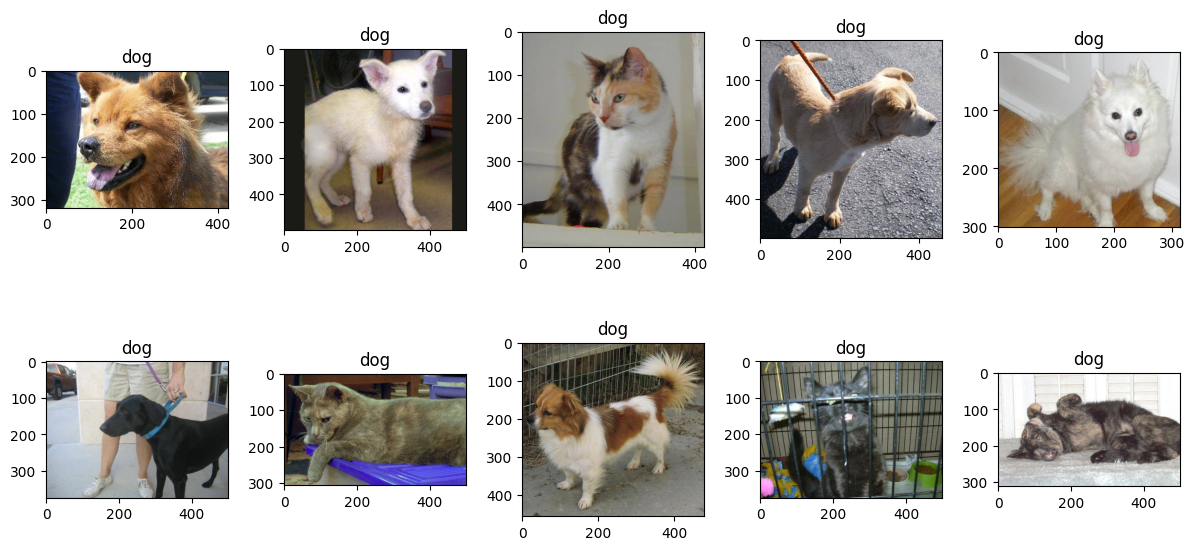

In [80]:
display_image_grid(test_images_filepaths)

**6.1.3 VGGNet**

- 신경망의 깊이의 영향을 확인하고자 만든 신경망
- 모든 합성곱 커널의 크기 : 3x3
- 모든 최대 풀링 커널의 크기 : 2x2
- 모든 스트라이드 : 2

In [3]:
#VGG19 구현
#라이브러리 호출

import copy #객체 복사
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
#copy : 객체 복사를 위해 사용
# - 얕은 복사(shallow copy)
# - 깊은 복사(deep copy)

# 1) 단순한 객체 복사
original = [1, 2, 3]
copy_o = original
print(copy_o)

copy_o[2] = 10
print(copy_o)
print(original)

[1, 2, 3]
[1, 2, 10]
[1, 2, 10]


In [5]:
# 2) 얕은 복사 : copy.copy()
import copy

original = [[1, 2], 3]

copy_shallow1 = copy.copy(original)
print(copy_shallow1) # >> [[1, 2], 3]

copy_shallow1[0] = 100
print(copy_shallow1) # >> [100, 3]
print(original) # >> [[1, 2], 3]

copy_shallow2 = copy.copy(original)
copy_shallow2[0].append(4) #첫 번째 리스트 [1, 2]에 4 추가
print(copy_shallow2) # >> [[1, 2, 4], 3]
print(original) # >> [[1, 2, 4], 3] (원래 값도 바뀜) #???????????????????????????????????????????????????????????????????????

[[1, 2], 3]
[100, 3]
[[1, 2], 3]
[[1, 2, 4], 3]
[[1, 2, 4], 3]


In [6]:
# 3) 깊은 복사 : copy.deepcopy()
import copy

original = [[1, 2], 3]
copy_deep1 = copy.deepcopy(original)
print(copy_deep1) # >> [[1, 2], 3]

copy_deep1[0] = 100
print(copy_deep1) # >> [100, 3]
print(original) # >> [[1, 2], 3]

copy_deep2 = copy.deepcopy(original)
copy_deep2[0].append(4)
print(copy_deep2) # >> [[1, 2, 4], 3]
print(original) # >> [[1, 2], 3]

[[1, 2], 3]
[100, 3]
[[1, 2], 3]
[[1, 2, 4], 3]
[[1, 2], 3]


In [7]:
#VGG모델 정의

class VGG(nn.Module) :
  def __init__(self, features, output_dim) : #합성곱 계층, 출력 클래스 수
    super().__init__()
    self.features = features #합성곱층
    self.avgpool = nn.AdaptiveAvgPool2d(7) #평균 풀링(<->최대 풀링)
    self.classifier = nn.Sequential(
        nn.Linear(512*7*7, 4096), #완전연결층 1
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096), #완전연결층 2
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, output_dim) #출력층
    )

  def forward(self, x) :
    x = self.features(x)
    x = self.avgpool(x)
    h = x.view(x.shape[0], -1)
    x = self.classifier(h)
    return x, h

In [8]:
#모델 유형 정의 : VGG + 층 개수

vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']

In [9]:
#VGG 계층 정의

def get_vgg_layers(config, batch_norm : bool) :
  layers = []
  in_channels = 3

  for c in config :
    assert c == 'M' or isinstance(c, int) # vgg11_config의 요소인 c가 'M'이 아니면 오류 / c가 int정수가 아니면 오류
    if c == 'M' : # 'M'이면 최대풀링 적용
      layers += [nn.MaxPool2d(kernel_size = 2)]
    else : # 숫자면 합성곱신경망 적용
      conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
      if batch_norm : # 배치정규화(평균0 분산1)가 적용될 경우 배치정규화+렐루 적용
        layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
      else :
        layers += [conv2d, nn.ReLU(inplace=True)]
      in_channels = c # 현재 출력 채널이 다음 층의 입력 채널이 됨

  return nn.Sequential(*layers)

In [10]:
#VGG11 합성곱 계층 생성
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm=True)

print(vgg11_layers) #배치정규화가 추가됨

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [11]:
#VGG11 전체에 대한 신경망 생성
OUTPUT_DIM = 2 #출력 클래스 개수(개, 고양이)
model = VGG(vgg11_layers, OUTPUT_DIM)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [12]:
#VGG11 사전 훈련된 모델 사용
import torchvision.models as models
pretrained_model = models.vgg11_bn(pretrained=True)
#vgg11_bn: VGG11 기본 모델에 배치정규화가 적용된 모델을 사용  /  pretrained=True: 미리 학습된 파라미터(사전 훈련된 모델) 사용

print(pretrained_model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [13]:
#이미지 데이터 전처리

train_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [14]:
#데이터세트 불러오기
train_path = '/content/drive/MyDrive/pytorch_ex/chap06/data/catanddog/train'
test_path = '/content/drive/MyDrive/pytorch_ex/chap06/data/catanddog/test'

train_dataset = torchvision.datasets.ImageFolder( # ImageFolder: 계층적인 폴더 구조를 가진 데이터세트 불러올 때 활용
    train_path, #훈련 세트를
    transform=train_transforms #훈련 전처리 방법으로 전처리
)

test_dataset = torchvision.datasets.ImageFolder(
    test_path,
    transform=test_transforms
)

print(len(train_dataset), len(test_dataset))

529 12


In [15]:
#훈련세트에서 훈련+검증으로 분할
n_train_examples = int( len(train_dataset) * 0.9 )
n_valid_examples = len(train_dataset) - n_train_examples

train_data, valid_data = data.random_split(train_dataset, [n_train_examples, n_valid_examples])

In [16]:
#검증 세트 전처리
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [17]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_dataset)}')

Number of training examples: 476
Number of validation examples: 53
Number of testing examples: 12


In [18]:
#데이터로더 이용하여 데이터를 메모리로 가져오기(배치 크기만큼 나누어서)

train_iterator = data.DataLoader(train_data, shuffle=True, batch_size=128)
valid_iterator = data.DataLoader(valid_data, batch_size=128)
test_iterator = data.DataLoader(test_dataset, batch_size=128)

In [19]:
#옵티마이저, 손실 함수 지정
optimizer = optim.Adam(model.parameters(), lr=1e-7)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [20]:
#모델 정확도 측정 함수 정의

def calculate_accuracy(y_pred, y) :
  top_pred = y_pred.argmax(1, keepdim=True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float() / y.shape[0]
  return acc

In [21]:
#모델 학습 함수 정의

def train(model, iterator, optimizer, criterion, device) : #신경망, 데이터, 경사하강법, 손실함수, 장치cpu
  epoch_loss = 0
  epoch_acc = 0

  model.train()
  for (x, y) in iterator :
    x = x.to(device)
    y = y.to(device)

    optimizer.zero_grad()
    y_pred, _ = model(x)
    loss = criterion(y_pred, y)
    acc = calculate_accuracy(y_pred, y)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [22]:
#모델 성능 측정 함수 정의

def evaluate(model, iterator, criterion, device) :
  epoch_loss = 0
  epoch_acc = 0

  model.eval()
  with torch.no_grad() :
    for (x, y) in iterator :
      x = x.to(device)
      y = y.to(device)
      y_pred, _ = model(x)
      loss = criterion(y_pred, y)
      acc = calculate_accuracy(y_pred, y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [23]:
#모델 학습 시간 측정 함수

def epoch_time(start_time, end_time) :
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

In [ ]:
#모델 학습
EPOCHS = 5
best_valid_loss = float('inf')
for epoch in range(EPOCHS) :
  start_time = time.monotonic()
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

  if valid_loss < best_valid_loss : #valid_loss가 가장 작은 값을 구하고 그 상태의 모델을 VGG-model.pt 이름으로 저장
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), '/content/drive/MyDrive/pytorch_ex/chap06/data/VGG-model.pt')

  end_time = time.monotonic()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\t Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%')

In [ ]:
#테스트 세트 성능 측정
model.load_state_dict(torch.load('/content/drive/MyDrive/pytorch_ex/chap06/data/VGG-model.pt'))
test_loss, test_acc = evaluate(model,test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

In [ ]:
#테스트 세트 예측 확인
def get_predictions(model, iterator) :
  model.eval()
  images = []
  labels = []
  probs = []

  with torch.no_grad() :
    for (x, y) in iterator :
      x = x.to(device)
      y_pred, _ = model(x)
      y_prob = F.softmax(y_pred, dim=-1)
      top_pred = y_prob.argmax(1, keepdim=True) #axis=1(열)을 따라 가장 큰 값을 찾음 / 입력텐서와 같은 크기로 출력텐서 유지
      images.append(x.cpu())
      labels.append(y.cpu())
      probs.append(y_prob.cpu())

  images = torch.cat(images, dim=0) #이미지들을 행 기준으로 이어붙임
  labels = torch.cat(labels, dim=0)
  probs = torch.cat(probs, dim=0)
  return images, labels, probs

In [ ]:
#예측 중에서 정확하게 예측한 것을 추출
images, labels, probs = get_predictions(model, test_iterator)
pred_labels = torch.argmax(probs, 1)
corrects = torch.eq(labels, pred_labels) #예측과 정답이 같은지 비교
correct_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects) :
  if correct :
    correct_examples.append( (image, label, prob) )

correct_examples.sort(reverse=True, key=lambda x: torch.max(x[2], dim=0).values)

In [1]:
#이미지 출력을 위해, 왜곡 되돌리는 전처리
def normalize_image(image) :
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min=image_min, max=image_max) #주어진 최대,최소 범위 내에 이미지가 위치하게 함
  image.add_(-image.min).div_(image_max - image_min + 1e-5)
  return image

In [1]:
#모델이 정확하게 예측한 이미지 출력 함수

def plot_most_correct(correct, classes, n_images, normalize=True) :
  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))
  fig = plt.figure(figsize=(25,20))
  for i in range(rows*cols) :
    ax = fig.add_subplot(rows, cols, i+1)
    image, true_label, probs = correct[i]
    image = image.permute(1, 2, 0)
    true_prob = probs[true_label]
    correct_prob, correct_label = torch.max(probs, dim=0)
    true_class = classes[true_label]
    correct_class = classes[correct_label]

    if normalize :
      image = normalize_image(image) #본래 이미지로 출력하기 위해 normalize_image 함수 호출

    ax.imshow(image.cpu().numpy())
    ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                 f'pred label: {correct_class} ({correct_prob:.3f})')
    ax.axis('off')

  fig.subplots.adjust(hspac=0.4)

In [ ]:
#예측 결과 이미지 출력
classes = test_dataset.classes
N_IMAGES = 5
plot_most_correct(correct_examples, classes, N_IMAGES)

**6.1.4 GoogleLeNet**

- AlexNet(합성곱5, 완전연결층2, 출력층 1000클래스) 이후 망을 넓혀(층뿐만 아니라 각 층의 유닛도 늘림) 성능을 높이려는 노력이 많았음
- 인셉션(inception) 모듈 : 특징을 효율적으로 추출하기 위하여 1x1, 3x3, 5x5의 합성곱 연산 수행항
- 희소 연결(sparse connectivity) : 기존의 합성곱, 풀링, 완전연결층이 서로 밀집하게 연결된 신경망 대신, 관련성(correlation)이 높음 노드끼리만 연결하는 방법 => 연산량이 적어지며, 과적합과 기울기 소멸 문제 해결

**6.1.5 ResNet**

- 깊이(층수)를 깊게 했을 때, 성능이 좋아지다 일정 구역 이상일 시 성능 저하 문제 해결하기 위해 등장
- 잔차(residual) : H(x) - x, Output에 이전 레이어에서 학습했던 정보를 연결함으로써 추가적으로만 학습해야 할 정보
- 아이덴티티 매핑(identity mapping) : 입력 x를 출력층에 더해 추가적인 부분만 학습하여 연산량을 줄이고, 입력과 출력의 차원을 같게 함

In [1]:
#라이브러리 호출
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import time

import cv2
from torch.utils.data import DataLoader, Dataset
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
## 네임드튜플 : 튜플의 성질, 인덱스와 키값으로 접근 가능

from collections import namedtuple

student = namedtuple('student', ['name', 'age', 'DOB']) #네임드튜플 정의 : 네임드튜플의 이름, 키값
S = student('Sally', '19', '181')

print('The student age using index is :', end='')
print(S[1]) #인덱스로 데이터 접근

print('The student name using keyname is :', end='')
print(S.name) #키 값을 이용한 데이터 접근

The student age using index is :19
The student name using keyname is :Sally


In [3]:
#이미지 데이터 전처리
class ImageTransform() :
  def __init__(self, resize, mean, std) :
    self.data_transform = {
       'train' : transforms.Compose([                    #훈련세트 이미지에 대한 전처리
           transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
           transforms.RandomHorizontalFlip(),
           transforms.ToTensor(),
           transforms.Normalize(mean, std)
       ]),
      'val' : transforms.Compose([              #검증세트, 테스트세트 이미지에 대한 전처리
          transforms.Resize(256),
          transforms.CenterCrop(resize),
          transforms.ToTensor(),
          transforms.Normalize(mean, std)
      ])
    }

  def __call__(self, img, phase) :
    return self.data_transform[phase](img)

In [4]:
#변수에 대한 값 정의
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [5]:
#훈련과 테스트 데이터셋 불러오기

cat_directory = r'/content/drive/MyDrive/pytorch_ex/chap06/data/dogs-vs-cats/Cat'
dog_directory = r'/content/drive/MyDrive/pytorch_ex/chap06/data/dogs-vs-cats/Dog'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)]) #고양이 이미지 데이터
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)]) #강아지 이미지 데이터
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

In [6]:
#데이터셋을 훈련, 검증, 테스트로 분리
random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[400:-10]
test_images_filepaths = correct_images_filepaths[-10:]

print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


In [7]:
#데이터 전처리 적용, 레이블(개1, 고양이0) 구분
class DogvsCatDataset(Dataset) :
  def __init__(self, file_list, transform=None, phase='train') :
    self.file_list = file_list
    self.transform = transform
    self.phase = phase

  def __len__(self) :
    return len(self.file_list) #전체 데이터 크기

  def __getitem__(self, idx) :
    img_path = self.file_list[idx] #해당 인덱스의 데이터 경로
    img = Image.open(img_path) #해당 인덱스 데이터 오픈
    img_transformed = self.transform(img, self.phase) #해당 이미지를, 해당 방법으로 전처리

    label = img_path.split('/')[-1].split('.')[0] #'이름' 가져옴
    if label == 'dog' :
      label = 1
    elif label == 'cat' :
      label = 0

    return img_transformed, label

In [8]:
#이미지 데이터세트 정의
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size()) #첫 번쨰 이미지 크기 : 3(컬러)x224x224
print(train_dataset.__getitem__(index)[1]) #1이면 개, 0이면 고양이

torch.Size([3, 224, 224])
0


In [9]:
#데이터셋의 데이터를 메모리로 불러오기

train_iterator = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_iterator = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train':train_iterator, 'val':valid_iterator}

batch_iterator = iter(train_iterator)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1])


In [10]:
#기본 블록 정의(ex: 합성곱층, 완전연결층, ...)
#(3x3) 합성곱 2개로 구성
#ResNet18, ResNet34에서 사용됨

class BasicBlock(nn.Module) :
  expansion = 1

  def __init__(self, in_channels, out_channels, stride=1, downsample=False) :
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False) #3x3 합성곱층
    self.bn1 = nn.BatchNorm2d(out_channels) #배치 정규화(평균0 분산1)

    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False) #3x3 합성곱층
    self.relu = nn.ReLU(inplace=True)

    if downsample :
      conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False) #stride=2를 가진 1x1 합성곱층
      bn = nn.BatchNorm2d(out_channels)
      downsample = nn.Sequdntial(conv, bn)
    else :
      downsample = None
    self.downsample = downsample #다운샘플(->블록 간 입출력 형태 맞춤)층

  def forward(self, x) :
    i = x
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)

    if self.downsample is not None :
      i = self.downsample(i)

    x += i #다운샘플한 처음 x 추가 or 그냥 x 추가
    x = self.relu(x)

    return x

In [62]:
#병목 블록 정의
#(1x1), (3x3), (1x1) 합성곱층으로 구성
#ResNet50, ResNet101, ResNet152에서 사용

class Bottleneck(nn.Module) :
  expansion = 4

  def __init__(self, in_channels, out_channels, stride=1, downsample=False) :
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False) #1x1 합성곱층
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False) #3x3 합성곱층
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.conv3 = nn.Conv2d(out_channels, self.expansion*out_channels, kernel_size=1, stride=1, bias=False) #1x1 합성곱층
                                                         #다음 계층의 입력 채널 수와 일치하도록 self.expansion*out_channels 해줌
    self.bn3 = nn.BatchNorm2d(self.expansion*out_channels)
    self.relu = nn.ReLU(inplace=True)
    if downsample :
      conv = nn.Conv2d(in_channels, self.expansion*out_channels, kernel_size=1, stride=stride, bias=False)
      bn = nn.BatchNorm2d(self.expansion*out_channels)
      downsample = nn.Sequential(conv, bn)
    else :
      downsample = None
    self.downsample = downsample

  def forward(self, x) :
    i = x
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.conv3(x)
    x = self.bn3(x)

    if self.downsample is not None :
      i = self.downsample(i)

    x += 1
    x = self.relu(x)
    return x

In [63]:
#ResNet 모델 네트워크

class ResNet(nn.Module) :
  def __init__(self, config, output_dim, zero_init_residual=False) : #네임드튜플 [block, n_blocks, channels] / 출력 클래스
    super().__init__()

    block, n_blocks, channels = config
    self.in_channels = channels[0]
    assert len(n_blocks) == len(channels) == 4

    self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn1 = nn.BatchNorm2d(self.in_channels)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
    self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride=2)
    self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride=2)
    self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d( (1,1) ) #평균 풀링
    self.fc = nn.Linear(self.in_channels, output_dim)

    if zero_init_residual :
      for m in self.modules() :
        if isinstance(m, Bottleneck) :
          nn.init.constant_(m.bn3.weight, 0)
        elif isinstance(m, BasicBlock) :
          nn.init.constant_(m.bn2.weight, 0)


  def get_resnet_layer(self, block, n_blocks, channels, stride=1) :
    layers = []
    if self.in_channels != block.expansion * channels :
      downsample = True #블록 간 채널 수 안 맞으므로 다운샘플 필요
    else :
      downsample = False

    layers.append( block(self.in_channels, channels, stride, channels) )
    for i in range(1, n_blocks) :
      layers.append( block(block.expansion*channels, channels) )

    self.in_channels = block.expansion * channels
    return nn.Sequential(*layers)


  def forward(self, x) :
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.avgpool(x)
    h = x.view(x.shape[0], -1)
    x = self.fc(h)
    return x, h

In [64]:
#ResNetConfig 네임드튜플 정의

ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [65]:
#기본 블록 사용하여 ResNetConfig 정의
resnet18_config = ResNetConfig(block=BasicBlock, n_blocks=[2,2,2,2], channels=[64,128])
resnet34_config = ResNetConfig(block=BasicBlock, n_blocks=[3,4,6,3], channels=[64, 128, 256, 512])

In [66]:
#병목 블록 사용하여 ResNetConfig 정의
resnet50_config = ResNetConfig(block=Bottleneck, n_blocks=[3,4,6,3], channels=[64,128,256,512])
resnet101_config = ResNetConfig(block=Bottleneck, n_blocks=[3,4,23,3], channels=[64,128,256,512])
resnet152_config = ResNetConfig(block=Bottleneck, n_blocks=[3,8,36,3], channels=[64,128,256,512])

In [67]:
pretrained_model = models.resnet50(pretrained=True)

In [68]:
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [69]:
#ResNet50_config을 사용한 ResNet 모델 사용

OUTPUT_DIM = 2  #2개의 출력 클래스(개, 고양이)
model = ResNet(resnet50_config, OUTPUT_DIM)
print(model )

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [70]:
#옵티마이저와 손실 함수 정의
optimizer = optim.Adam(model.parameters(), lr=1e-7) #모델의 파라미터(가중치)들에 대하여,  학습률: 1*10의 -7제곱
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [71]:
#모델의 정확도를 측정하는 함수 정의

def calculate_topk_accuracy(y_pred, y, k=2) :
  with torch.no_grad() :
    batch_size = y.shape[0]
    _, top_pred = y_pred.topk(k, 1) #(1) 주어진 텐서에서 가장 큰 값의 '인덱스' 반환
    top_pred = top_pred.t() #(2) 차원 0과 1을 전치
    correct = top_pred.eq(y.view(1, -1).expand_as(top_pred)) #top_pred만큼 늘린 y.view(1,-1)과 top_pred가 같은지 비교 -> true, false가 요소인 tensor 반환
    correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim=True)
    correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
    acc_1 = correct_1 / batch_size
    acc_k = correct_k / batch_size
  return acc_1, acc_k

In [72]:
# (1) .topk() : 주어진 텐서에서 가장 큰 값의 인덱스 반환

In [73]:
# (2) .t() : 차원 0과 1을 전치

In [82]:
#모델 학습 함수 정의
def train(model, iterator, optimizer, criterion, device) :
  epoch_loss = 0
  epoch_acc_1 = 0
  epoch_acc_5 = 0

  model.train()
  for (x, y) in iterator :
    x = x.to(device)
    y = y.to(device)
    print('1', end='')

    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred[0], y)
    print('2', end='')

    acc_1, acc_5 = calculate_topk_accuracy(y_pred[0], y)
    loss.backward()
    optimizer.step()
    print('3', end='')

    epoch_loss += loss.item()
    epoch_acc_1 += acc_1.item()
    epoch_acc_5 += acc_5.item()
    print('4')

  epoch_loss /= len(iterator)
  epoch_acc_1 /= len(iterator)
  epoch_acc_5 /= len(iterator)

  return epoch_loss, epoch_acc_1, epoch_acc_5

In [86]:
#모델 평가 함수 정의

def evaluate(model, iterator, criterion, device) :
  epoch_loss = 0
  epoch_acc_1 = 0
  epoch_acc_5 = 0

  model.eval()
  with torch.no_grad() :
    for (x, y) in iterator :
      x = x.to(device)
      y = y.to(device)
      y_pred = model(x)
      loss = criterion(y_pred[0], y)

      acc_1, acc_5 = calculate_topk_accuracy(y_pred[0], y)
      epoch_loss += loss.item()
      epoch_acc_1 += acc_1.item()
      epoch_acc_5 += acc_5.item()

  epoch_loss /= len(iterator)
  epoch_acc_1 /= len(iterator)
  epoch_acc_5 /= len(iterator)

  return epoch_loss, epoch_acc_1, epoch_acc_5

In [87]:
#모델 학습 시간 측정 함수 정의

def epoch_time(start_time, end_time) :
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins*60))
  return elapsed_mins, elapsed_secs

In [88]:
#모델 학습

best_valid_loss = float('inf')
EPOCHS = 10

for epoch in range(EPOCHS) :
  start_time = time.monotonic()

  train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)

  if valid_loss < best_valid_loss :
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), '/content/drive/MyDrive/pytorch_ex/chap06/data/ResNet-model.pt')

  end_time = time.monotonic()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  print( f'Epoch: {epoch+1:02} | Epoch time: {epoch_mins}m {epoch_secs}s' )
  print( f'\tTrain loss: {train_loss:.3f} | Train acc 01: {train_acc_1*100:6.2f}% | Train acc 05: {train_acc_5*100:6.2f}%')
  print( f'\tValid loss: {valid_loss:.3f} | Valid acc 01: {valid_acc_1*100:6.2f}% | Valid acc 05: {valid_acc_5*100:6.2f}%')

1234
1234
1234
1234
1234
1234
1234
1234
1234
1234
1234
1234
1234
Epoch: 01 | Epoch time: 5m 44s
	Train loss: 0.796 | Train acc 01:  50.48% | Train acc 05: 100.00%
	Valid loss: 0.728 | Valid acc 01:  51.19% | Valid acc 05: 100.00%
1234
1234
1234
1234
1234
1234
1234
1234
1234
1234
1234
1234
1234
Epoch: 02 | Epoch time: 5m 44s
	Train loss: 0.800 | Train acc 01:  50.24% | Train acc 05: 100.00%
	Valid loss: 0.760 | Valid acc 01:  51.19% | Valid acc 05: 100.00%
1234
1234
1234
1234
1234
1234
1234
1234
1234
1234
1234
1234
1234
Epoch: 03 | Epoch time: 5m 25s
	Train loss: 0.802 | Train acc 01:  49.76% | Train acc 05: 100.00%
	Valid loss: 0.776 | Valid acc 01:  51.19% | Valid acc 05: 100.00%
1234
1234
1234
1234
1234
1234
1234
1234
1234
1234
1234
1234
1234
Epoch: 04 | Epoch time: 5m 15s
	Train loss: 0.800 | Train acc 01:  50.24% | Train acc 05: 100.00%
	Valid loss: 0.789 | Valid acc 01:  51.19% | Valid acc 05: 100.00%
1234
1234
1234
1234
1234
1234
1234
1234
1234
1234
1234
1234
1234
Epoch: 05 | Epo

In [91]:
#테스트 데이터셋을 이용한 모델 예측

import pandas as pd
id_list = []
pred_list = []
_id = 0

with torch.no_grad() :
  for test_path in test_images_filepaths :
    img = Image.open(test_path)
    _id = test_path.split('/')[-1].split('.')[1]
    transform = ImageTransform(size, mean, std)
    img = transform(img, phase='val')
    img = img.unsqueeze(0)
    img = img.to(device)

    model.eval()
    outputs = model(img)
    preds = F.softmax(outputs[0], dim=1)[:, 1].tolist()
    id_list.append(_id)
    pred_list.append(preds[0])

res = pd.DataFrame({
    'id' : id_list,
    'label' : pred_list
})

res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('/content/drive/MyDrive/pytorch_ex/chap06/data/ResNet.csv', index=False)

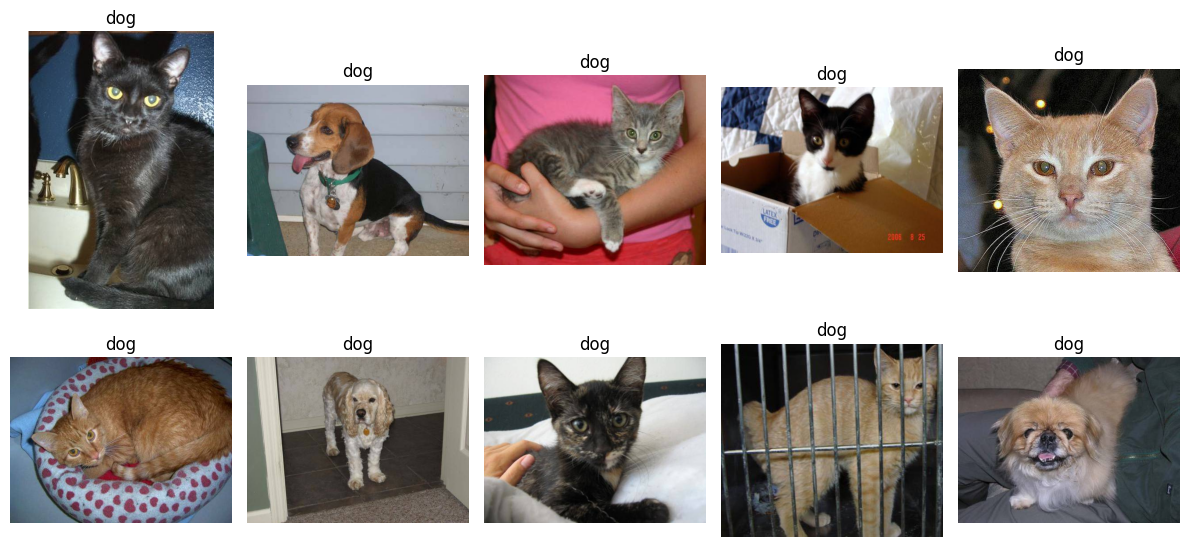

In [92]:
#모델 예측에 대한 결과 출력

class_ = classes = {0:'cat', 1:'dog'}

def display_image_grid(images_filepaths, predicted_labels=(), cols=5) :
  rows = len(images_filepaths) // cols
  figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
  for i, image_filepath in enumerate(images_filepaths) :
    image = cv2.imread(image_filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    a = random.choice(res['id'].values)
    label = res.loc[res['id'] == a, 'label'].values[0]

    if label > 0/5 :
      label = 1
    else :
      label = 0
    ax.ravel()[i].imshow(image)
    ax.ravel()[i].set_title(class_[label])
    ax.ravel()[i].set_axis_off()
  plt.tight_layout()
  plt.show()
display_image_grid(test_images_filepaths)

# 6.2 객체 인식을 위한 신경망

**객체 인식(object detection) : 이미지나 영상 내에 있는 객체를 식별하는 컴퓨터 비전 기술**

- (1) 분류 문제 : 이미지나 영상 내에 있는 여러 객체에 대해, 각 객체가 무엇인지
- (2) 위치 검출 문제(localization) : 해당 객체 위치가 어디인지 박스(bounding box)로 나타냄

1단계 객체 인식 : 분류 + 위치 검출 동시에 행함

    - 속도 빠름
    - 정확도 떨어짐

2단계 객체 인식 : 분류 -> 위치검출 순차적으로 행함

    - 속도 느림
    - 정확도 높음

활용 : 자율 주행 자동차, CCTV, 무인 점포

---



**6.2.1 R-CNN(Region-based CNN)**

: 이미지 분류 수행하는 CNN + 이미지에서 객체가 있을 만한 영역을 제안해 주는 후보 영역 알고리즘

- 수행 과정

  1. 이미지 삽입 : 이미지를 입력으로 받음
  2. 후보 영역 추출 : 선택적 탐색 알고리즘으로 2000개의 바운딩 박스(bounding box) 추출, 잘라내고(cropping), CNN 모델에 넣기 위해 같은 크기(227x227)로 통일(wrapping)
    - 선택적 탐색 : 객체 인식이나 검출을 위하여 가능한 후보 영역을 알아내는 방법
    - 후보 영역 : 영상/이미지에서 객체가 있을 법한 영역
  3. 크기가 동일한 이미지 2000개에 각각 CNN 적용
  4. 각각 분류 진행하여 결과 도출

- 단점

  - 수행 과정이 복잡함
  - 긴 학습 시간과 대용량 저장 공간
  - 객체 검출(object detection) 속도 문제

**6.2.2 공간 피라미드 풀링(spatial pyramid pooling)**

: 입력 이미지 크기에 관계없이 합성곱층을 통과시키고, 완전연결층에 전달되기 전에 특성 맵들을 동일한 크기로 조절해주는 풀링층을 적용하는 기법

- R-CNN과의 차이점

    - R-CNN : 완전 연결층을 위해 입력 이미지의 크기가 고정되어 있음
     
      -> 입력 이미지를 고정된 크기로 자르거나(crop), 비율 조정(wrap) 필요

      -> 물체의 일부분이 잘리거나 본래의 생김새와 달라짐 (원본 이미지의 훼손)

    - 공간 피라미드 풀링 : 입력 이미지의 크기를 조절하지 않고 합성곱층 통과시킴

      -> 원본 이미지 특징이 훼손되지 않는 특성 맵을 얻을 수 있음

**6.2.3 Fast R-CNN**

: Rol 풀링을 도입하여, 선택적 탐색에서 찾은 바운딩 박스 정보가 CNN을 통과하면서 유지되도록 함

-> 바운딩 박스마다 CNN을 돌리는 시간을 단축할 수 있음

- Rol 풀링 : 크기가 다른 특성 맵의 영역마다 스트라이드를 다르게 최대 풀링을 적용 -> 완전연결층 전에 크기를 동일하게 맞춤

**6.2.4 Faster R-CNN**

: Fast R-CNN + 후보 영역 추출을 신경망(NN)으로 구현

- 객체 유무 이진 분류
- 바운딩 박스 회귀(박스 크기 및 모양)